In [1]:
###########
# Generic #
###########
import json
import os
from pathlib import Path
import sys

########
# Libs #
########
import cv2
import hydra
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import seaborn as sns
import skimage.io as io
# from pycocotools.coco import COCO
# from PIL import Image
from peekingduck.pipeline.nodes.draw import bbox
from peekingduck.pipeline.nodes.model import efficientdet
import tensorflow as tf


##########
# Custom #
##########
# sys.path.append('.')
# from eda_pipeline import DataExplorer


###########
# Configs #
###########
SRC_DIR = Path.cwd().parent
DATA_DIR = os.path.join(SRC_DIR, "data")
logger = logging.getLogger(__name__)

EFFICIENTDET_CONFIG = {
    "model_type": 0,
    "score_threshold": 0.5,
    "detect_ids": [0],
}

DRAW_BBOX_CONFIG = {
    "show_labels":True
}

OUTPUT_PATH = os.path.join(SRC_DIR, "data",  "output", "output.csv")

%load_ext autoreload
%autoreload 2

Found 4 files belonging to 2 classes.
2022-04-18 08:08:26 peekingduck.pipeline.nodes.model.efficientdet  INFO:  Config for node model.efficientdet is updated to: 'model_type': 0 
2022-04-18 08:08:26 peekingduck.pipeline.nodes.model.efficientdet  INFO:  Config for node model.efficientdet is updated to: 'score_threshold': 0.5 
2022-04-18 08:08:26 peekingduck.pipeline.nodes.model.efficientdet  INFO:  Config for node model.efficientdet is updated to: 'detect_ids': [0] 
2022-04-18 08:08:29 peekingduck.pipeline.nodes.model.efficientdet_d04.efficientdet_files.detector  INFO:  Efficientdet graph model loaded with following configs: 
	Model type: D0, 
	Score Threshold: 0.5,  
2022-04-18 08:08:29 __main__  INFO:  Instantiate Model Node. 
2022-04-18 08:08:29 peekingduck.pipeline.nodes.draw.bbox  INFO:  Config for node draw.bbox is updated to: 'show_labels': True 


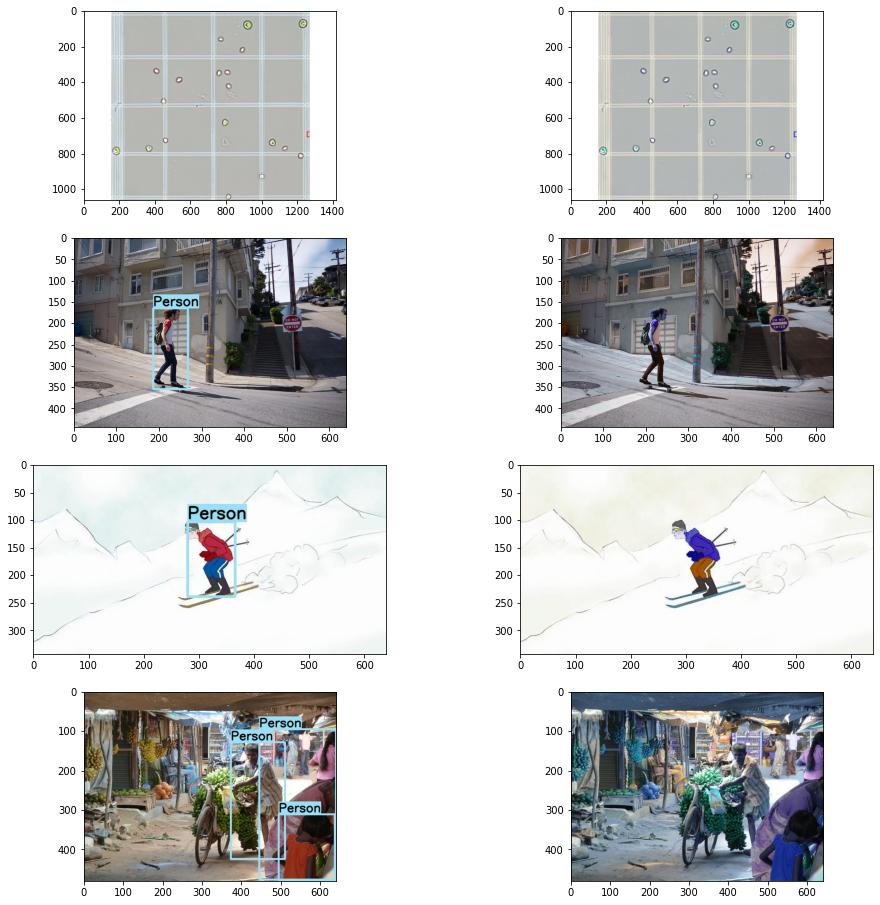

In [2]:
class PeekingDuckPipeline:
    """This class encapsulates the data preprocessing functionality that forms 
    part of the PeekingDuck pipeline.

    Attributes:
        logger: Logger object used to log events to.
        no: pandas DataFrame containing the final processed data.
        seed: Seed to use for data splitting function
    """
    def __init__(self, logger, model_node_type=None, model_config=None, draw_node_type=None, draw_config=None, data=None):
        self.logger = logger
        self.model_node_type = model_node_type
        self.model_config = model_config
        self.draw_node_type = draw_node_type
        self.draw_config = draw_config
        self.data = data

        self.model_node = None
        self.draw_node = None
        
        if model_node_type:
            self.set_model_node()
        if draw_node_type:
            self.set_draw_node()
    
    def set_model_node(self):
        """Sets the chosen model node.        
        """

        if self.model_node_type == "effdet":
            self.model_node = efficientdet.Node(**self.model_config)
            self.logger.info("Instantiate Model Node.")
        
        else:
            self.logger.error("Unsupported model node type specified")
            raise ValueError("Unsupported model node type specified!")

    def set_draw_node(self):
        """Sets the draw node.        
        """

        if self.draw_node_type == "draw_bbox":
            self.draw_node = bbox.Node(**self.draw_config)

        else:
            self.logger.error("Unsupported draw node type specified")
            raise ValueError("Unsupported draw node type specified!")

    ###################
    # Helper function #
    ###################
    def save_predict_output(self, output_df, output_path):
        """Saves the prediction output into
        a CSV file.

        Args:
            output_path (str): path where the output is saved
            output_data (Dict): output data to be saved 
        """
        output_df.to_csv(output_path, encoding='utf-8', index=False)
    
    def read_predict_output(self, output_path):
        """Reads the prediction output from
        a CSV file.

        Args:
            output_path (str): path where the output is saved

        Returns: 
            output_df (pd.DataFrame): output dataframe 
        """
        output_df = pd.read_csv(output_path)
        return output_df


    def visualise(self, pred_outputs_df):
        """Visualises the plot in a side-by-side comparison manner.
        
        Args:
            pred_outputs_df (pd.DataFrame): data of predicted output
        
        """

        num_of_imgs = pred_outputs_df.shape[0]
        figsize=(16, 16)
        _, ax = plt.subplots(num_of_imgs, 2, figsize=figsize)

        for i, row in pred_outputs_df.iterrows():
            
            # load images
            image_orig = cv2.imread(row['img_path'])
            image_orig = cv2.cvtColor(image_orig, cv2.COLOR_BGR2RGB)
            image_copy = cv2.cvtColor(image_orig.copy(), cv2.COLOR_RGB2BGR)

            # convert to PKD format
            bbox_input = {
                "img": image_orig,
                "bboxes": row["bboxes"],
                "bbox_labels": row["bbox_labels"],
            }

            # run pkd draw node
            _ = self.draw_node.run(bbox_input)

            # display images
            ax[i][0].imshow(image_orig)
            ax[i][1].imshow(image_copy)


    #################
    # Core function #
    #################
    def predict(self, dataset, save_output_option=False, output_path=None):
        """Gets prediction based on the dataset in Keras format
        
        Args:
            dataset (Keras Object): 
            save_output_option (str): 'True' to save output as json; 'False' to not save output as json

        Returns:
            bbox_outputs (List): predicted outputs
        """

        # inference pipeline
        pred_outputs = []
        for i, (element, path) in enumerate(zip(dataset, dataset.file_paths)):

            # load the original image
            # image_orig = cv2.imread(path)
            # image_orig = cv2.cvtColor(image_orig, cv2.COLOR_BGR2RGB)
            
            # load the image as numpy array
            image = cv2.cvtColor(element[0].numpy().astype("uint8")[0], cv2.COLOR_RGB2BGR)
            
            # run inference
            eff_det_input = {"img": image}
            eff_det_output = self.model_node.run(eff_det_input)
            
            # format the predicted bbox
            pred_output = {
                "bboxes": eff_det_output["bboxes"],
                "bbox_labels": eff_det_output["bbox_labels"],
                "img_path": path
            }
            
            pred_outputs.append(pred_output)

            pred_outputs_df = pd.DataFrame(pred_outputs)
            # save output into csv
            if save_output_option:
                # save to csv 
                self.save_predict_output(
                    output_df=pred_outputs_df, 
                    output_path=output_path
                )

        return pred_outputs_df

        

dataset = tf.keras.utils.image_dataset_from_directory(DATA_DIR, batch_size=1, shuffle=False)

pkd = PeekingDuckPipeline(
    logger=logger, 
    model_node_type="effdet", 
    model_config=EFFICIENTDET_CONFIG,
    draw_node_type="draw_bbox",
    draw_config=DRAW_BBOX_CONFIG
)

pred_outputs = pkd.predict(
    dataset=dataset,
    save_output_option=True,
    output_path=OUTPUT_PATH
)

pkd.visualise(pred_outputs_df=pred_outputs)